In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

## Загрузка данных

In [3]:
df = pd.read_csv('6_class.csv').drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

## Предобработка и анализ данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [5]:
df['Star type'] = df['Star type'].astype(str)

In [6]:
obj_cols = []
dig_cols = []

for column in df.columns:
    if df[column].dtype == object:
        obj_cols.append(column)
    else:
        dig_cols.append(column)

In [7]:
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first')


In [8]:
#dig_cols.remove('Temperature (K)')

In [9]:
df[dig_cols] = scaler.fit_transform(df[dig_cols])


In [10]:
encoded = encoder.fit_transform(df[obj_cols]).toarray()
encoded_df = pd.DataFrame(data=encoded, columns=encoder.get_feature_names_out())
df.drop(columns=obj_cols, inplace=True)
df = pd.concat([df, encoded_df], axis=1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    torch.FloatTensor(df.drop('Temperature (K)', axis=1).values),
    torch.FloatTensor(df['Temperature (K)'].values),
    test_size=.2,
    random_state=42
)

## Построение базовой нейронной сети

In [12]:
class Net(nn.Module):
    def __init__(self, input_n, layer1_n, layer2_n, output_n):

        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_n, layer1_n)
        self.bn1 = nn.BatchNorm1d(layer1_n)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(layer1_n,layer2_n)
        self.bn2 = nn.BatchNorm1d(layer2_n)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(layer2_n, output_n)

    def forward(self, x):

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [13]:
net = Net(26, 10, 10, 1)

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [15]:
loss = nn.modules.loss.MSELoss()

In [16]:
num_epoches = 500

In [17]:
for epoch in range(num_epoches):

    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_val = loss(preds, y_train)
    loss_val.backward()
    optimizer.step()

    if epoch==num_epoches-1:
        net.eval()
        test_preds = net(X_test)
        test_loss = loss(test_preds.flatten(), y_test)
        print(test_loss)

tensor(1.1568, grad_fn=<MseLossBackward0>)


In [18]:
target_mean = scaler.mean_[dig_cols.index('Temperature (K)')]
target_std = scaler.scale_[dig_cols.index('Temperature (K)')]

test_preds_real = test_preds * target_std + target_mean
y_test_real = y_test * target_std + target_mean

for real, pred in zip(y_test_real[:-10], test_preds_real[:-10]):
    print(f"Real: {real.item():.2f}, Predicted: {pred.item():.2f}")


Real: 16500.00, Predicted: 14957.23
Real: 2637.00, Predicted: 2382.18
Real: 4980.00, Predicted: 51549.60
Real: 33421.00, Predicted: 17730.41
Real: 11096.00, Predicted: 26389.52
Real: 4287.00, Predicted: 2014.78
Real: 27739.00, Predicted: 33461.91
Real: 12010.00, Predicted: 14320.77
Real: 2700.00, Predicted: 2685.03
Real: 14520.00, Predicted: 14877.65
Real: 3600.00, Predicted: 2705.06
Real: 24020.00, Predicted: 22599.82
Real: 3610.00, Predicted: 3463.83
Real: 17383.00, Predicted: 17603.54
Real: 3399.00, Predicted: 3436.36
Real: 24145.00, Predicted: 25996.69
Real: 2889.00, Predicted: 2457.07
Real: 3340.00, Predicted: 2900.10
Real: 14060.00, Predicted: 14771.70
Real: 3225.00, Predicted: 2271.97
Real: 2861.00, Predicted: 2513.97
Real: 3441.00, Predicted: 2944.89
Real: 38940.00, Predicted: 35643.17
Real: 39000.00, Predicted: 33942.54
Real: 18000.00, Predicted: 50430.17
Real: 29560.00, Predicted: 11135.89
Real: 3600.00, Predicted: 2973.95
Real: 15680.00, Predicted: 17962.45
Real: 8829.00, Pr

In [19]:
y_test_real = np.array(y_test_real)

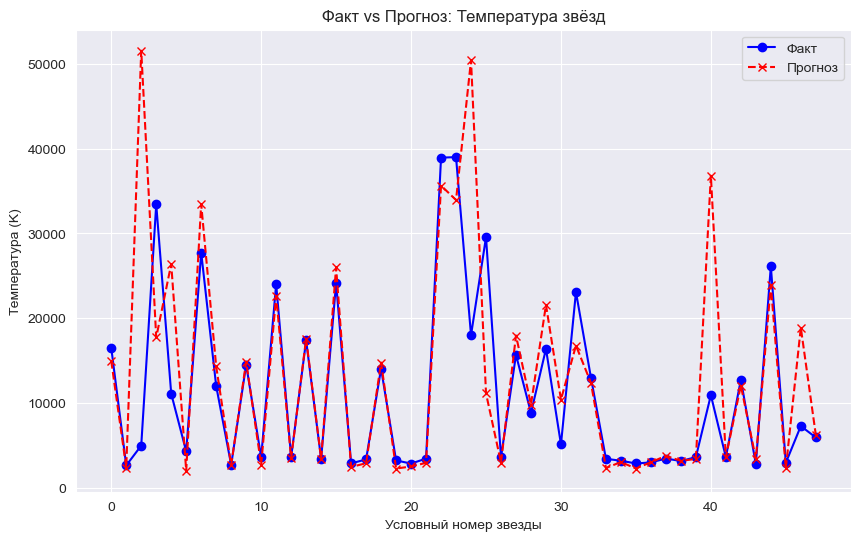

In [20]:
# Построение графика "Факт — Прогноз"
plt.figure(figsize=(10, 6))  # Задаём размер графика
plt.plot(range(len(y_test_real)), y_test_real, label='Факт', marker='o', linestyle='-',
         color='blue')  # Реальные значения
plt.plot(range(len(test_preds_real)), test_preds_real.detach().numpy(), label='Прогноз', marker='x', linestyle='--',
         color='red')  # Предсказанные значения
plt.xlabel('Условный номер звезды')  # Подпись оси X
plt.ylabel('Температура (K)')  # Подпись оси Y
plt.title('Факт vs Прогноз: Температура звёзд')  # Заголовок графика
plt.legend()  # Легенда
plt.grid(True)  # Сетка для удобства
plt.show()  # Показать график

## Улучшение нейронной сети

In [73]:
class Net(nn.Module):
    def __init__(self, input_n, layer1_n, layer2_n, output_n, dropout_rate):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_n, layer1_n)
        self.bn1 = nn.BatchNorm1d(layer1_n)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(layer1_n, layer2_n)
        self.bn2 = nn.BatchNorm1d(layer2_n)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(layer2_n, output_n)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [74]:
def calculate_rmse(predictions, targets, mean, std):
    preds_real = predictions * std + mean
    targets_real = targets * std + mean
    return torch.sqrt(torch.mean((preds_real - targets_real) ** 2)).item()

In [75]:
# Параметры для перебора
dropout_rates = [0.0, 0.1]  # Уровни dropout
batch_sizes = [8 ,16, 32, 64]  # Размеры батча
num_epochs = 300  # Увеличим число эпох для лучшей сходимости
learning_rate = 1e-3

# Хранение результатов
results = []
best_rmse = float('inf')
best_preds = None
best_params = None

In [76]:
from torch.utils.data import TensorDataset, DataLoader
from itertools import product

# Перебор параметров
for dropout_rate, batch_size in product(dropout_rates, batch_sizes):
    print(f"\nTesting: Dropout = {dropout_rate}, Batch Size = {batch_size}")

    # Создание модели
    net = Net(26, 8, 5, 1, dropout_rate)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Подготовка данных с батчами
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Обучение
    for epoch in range(num_epochs):
        net.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = net(X_batch).flatten()
            loss_val = loss_fn(preds, y_batch)
            loss_val.backward()
            optimizer.step()

    # Оценка на тесте
    net.eval()
    with torch.no_grad():
        test_preds = net(X_test).flatten()
        rmse = calculate_rmse(test_preds, y_test, scaler.mean_[dig_cols.index('Temperature (K)')],
                            scaler.scale_[dig_cols.index('Temperature (K)')])

    print(f"Test RMSE: {rmse:.2f}")
    results.append({'Dropout': dropout_rate, 'Batch Size': batch_size, 'RMSE': rmse})

    # Сохранение лучшей модели
    if rmse < best_rmse:
        best_rmse = rmse
        best_preds = test_preds
        best_params = {'Dropout': dropout_rate, 'Batch Size': batch_size}



Testing: Dropout = 0.0, Batch Size = 8
Test RMSE: 5609.30

Testing: Dropout = 0.0, Batch Size = 16
Test RMSE: 6335.91

Testing: Dropout = 0.0, Batch Size = 32
Test RMSE: 7309.33

Testing: Dropout = 0.0, Batch Size = 64
Test RMSE: 5996.64

Testing: Dropout = 0.1, Batch Size = 8
Test RMSE: 5622.29

Testing: Dropout = 0.1, Batch Size = 16
Test RMSE: 6552.01

Testing: Dropout = 0.1, Batch Size = 32
Test RMSE: 6938.22

Testing: Dropout = 0.1, Batch Size = 64
Test RMSE: 5417.15



Результаты перебора параметров:
   Dropout  Batch Size         RMSE
0      0.0           8  5609.302246
1      0.0          16  6335.909180
2      0.0          32  7309.328125
3      0.0          64  5996.644043
4      0.1           8  5622.293945
5      0.1          16  6552.012207
6      0.1          32  6938.217773
7      0.1          64  5417.151367


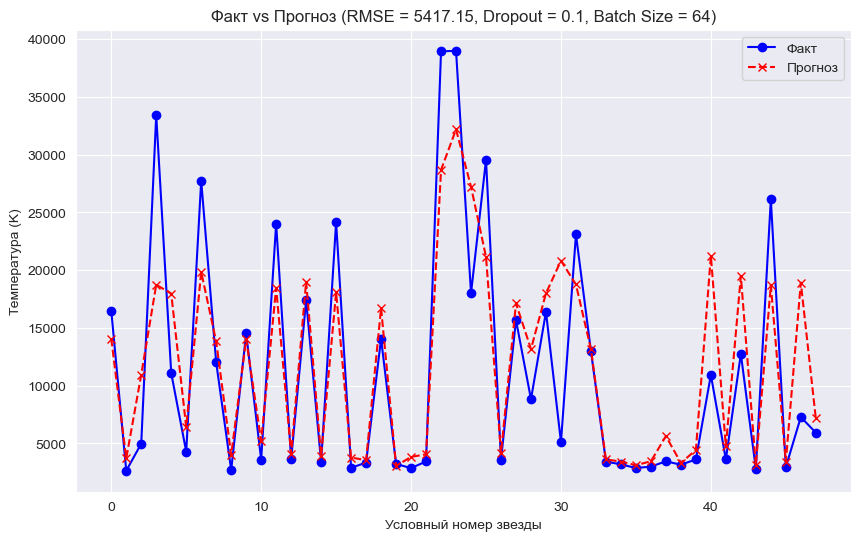


Вывод:
Лучшая модель: Dropout = 0.1, Batch Size = 64, RMSE = 5417.15
RMSE не удалось снизить ниже 4500. Рекомендуется увеличить число эпох, нейронов или изменить lr.


In [77]:
# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results)

# Вывод таблицы результатов
print("\nРезультаты перебора параметров:")
print(results_df)

# График "Факт — Прогноз" для лучшей модели
target_mean = scaler.mean_[dig_cols.index('Temperature (K)')]
target_std = scaler.scale_[dig_cols.index('Temperature (K)')]
test_preds_real = best_preds * target_std + target_mean
y_test_real = y_test * target_std + target_mean

plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_real)), y_test_real.numpy(), label='Факт', marker='o', linestyle='-', color='blue')
plt.plot(range(len(test_preds_real)), test_preds_real.detach().numpy(), label='Прогноз', marker='x', linestyle='--', color='red')
plt.xlabel('Условный номер звезды')
plt.ylabel('Температура (K)')
plt.title(f'Факт vs Прогноз (RMSE = {best_rmse:.2f}, Dropout = {best_params["Dropout"]}, Batch Size = {best_params["Batch Size"]})')
plt.legend()
plt.grid(True)
plt.show()

# Вывод
print("\nВывод:")
if best_rmse < 4500:
    print(f"Лучшая модель: Dropout = {best_params['Dropout']}, Batch Size = {best_params['Batch Size']}, RMSE = {best_rmse:.2f}")
    print("RMSE достигло значения ниже 4500, что удовлетворяет условию.")
else:
    print(f"Лучшая модель: Dropout = {best_params['Dropout']}, Batch Size = {best_params['Batch Size']}, RMSE = {best_rmse:.2f}")
    print("RMSE не удалось снизить ниже 4500. Рекомендуется увеличить число эпох, нейронов или изменить lr.")


## Выводы